In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1

        class_counts = np.zeros((m, model.n_classes_))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        
        sum_posteriors = np.zeros((test.shape[0], self.n_classes))
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
                
        return np.argmax(sum_posteriors, axis=1)

In [4]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_3d_rotation(angle_params=[0,0,0], acorn=None):
    if acorn is not None:
            np.random.seed(acorn)

    a,b,c = angle_params[0], angle_params[1], angle_params[2]
    
    R1 = np.array([
        [np.cos(a), -np.sin(a), 0],
        [np.sin(a), np.cos(a), 0],
        [0, 0, 1]
    ])
    
    R2 = np.array([
        [np.cos(b), 0, np.sin(b)],
        [0, 1, 0],
        [-np.sin(b), 0, np.cos(b)]
    ])
    
    R3 = np.array([
        [np.cos(c), -np.sin(c), 0],
        [np.sin(c), np.cos(c), 0],
        [0, 0, 1]
    ])
    
    R = R1 @ R2 @ R3 # R3 @ R2 @ R1
    
#     q = np.random.normal(0,1,4)
#     q = q / np.sqrt(np.sum(q**2))
    
#     R1 = np.array([np.cos()])

#     R = np.array([
#         [1 -2*(q[2]**2+q[3]**2), 2*(q[1]*q[2]-q[3]*q[0]), 2*(q[1]*q[3]+q[2]*q[0])],
#         [2*(q[1]*q[2]+q[3]*q[0]), 1-2*(q[1]**2+q[3]**2), 2*(q[2]*q[3]-q[1]*q[0])],
#         [2*(q[1]*q[3] - q[2]*q[0]), 2*(q[2]*q[3]+q[1]*q[0]), 1-2*(q[1]**2+q[2]**2)]
#     ])
    return R

def generate_parity(n, d=2, angle_params=None, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-2, 2, size=(10*n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
        R = generate_2d_rotation(angle_params)
        X = X @ R
        inds = (abs(X[:, 0]) < 1) + (abs(X[:, 1]) < 1)
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1)][:n]
        
        
    if d==3:
        if angle_params is None:
            pass
        R = generate_3d_rotation(angle_params[0], angle_params[1], angle_params[2])
        X = X @ R
        Y = Y[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1) * (abs(X[:, 2]) < 1)][:n]
        X = X[(abs(X[:, 0]) < 1) * (abs(X[:, 1]) < 1) * (abs(X[:, 2]) < 1)][:n]
        
            
    return X, Y.astype(int)

In [5]:
def transfer_experiment(nx, nz, d, angle_params=np.pi/2, m=100, subsample=0.32, return_posteriors=False, acorn=None):
    if acorn is None:
        np.random.seed(acorn)

    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    errors = np.zeros(6)

    # Source task
    X, labelsX = generate_parity(nx, d, 0)
    testX, test_labelsX = generate_parity(m, d, 0)
    
    # Target task
    Z, labelsZ = generate_parity(nz, d, angle_params)
    testZ, test_labelsZ = generate_parity(m, d, angle_params)
    

    lifelong_forest = LifelongForest()
    lifelong_forest.new_forest(X, labelsX, n_estimators=Tx)
    lifelong_forest.new_forest(Z, labelsZ, n_estimators=Tz)
    
    
    df_task1=lifelong_forest.predict(testX, representation=0, decider=0)
    tf_task1=lifelong_forest.predict(testX, representation=1, decider=0)
    llf_task1=lifelong_forest.predict(testX, representation='all', decider=0)
 
    df_task2=lifelong_forest.predict(testZ, representation=1, decider=1)
    tf_task2=lifelong_forest.predict(testZ, representation=0, decider=1)
    llf_task2=lifelong_forest.predict(testZ, representation='all', decider=1)
    
    
    errors[0] = 1 - np.sum(df_task1 == test_labelsX)/m
    errors[1] = 1 - np.sum(tf_task1 == test_labelsX)/m
    errors[2] = 1 - np.sum(llf_task1 == test_labelsX)/m
    
    errors[3] = 1 - np.sum(df_task2 == test_labelsZ)/m
    errors[4] = 1 - np.sum(tf_task2 == test_labelsZ)/m
    errors[5] = 1 - np.sum(llf_task2 == test_labelsZ)/m
    
    
    if return_posteriors:
        import itertools
        # returns posteriors for a fixed mesh..
        mesh_=np.array(list(itertools.product(np.arange(-1, 1+0.05, step=0.05), np.arange(-1, 1+0.05, step=0.05))))
        
        posteriors_structX_estX=lifelong_forest._estimate_posteriors(mesh_, representation=0, decider=0)
        posteriors_structZ_estX=lifelong_forest._estimate_posteriors(mesh_, representation=1, decider=0)
        
        posteriors_structZ_estZ=lifelong_forest._estimate_posteriors(mesh_, representation=1, decider=1)
        posteriors_structX_estZ=lifelong_forest._estimate_posteriors(mesh_, representation=0, decider=1)
                    
        return posteriors_structX_estX, posteriors_structZ_estX, posteriors_structZ_estZ, posteriors_structX_estZ
    else:
        return errors

In [476]:
# fig 1 - N-XOR to XOR (left - XOR / NXOR, center - Error on XOR (DF/TF), right - posteriors (DF/TF))

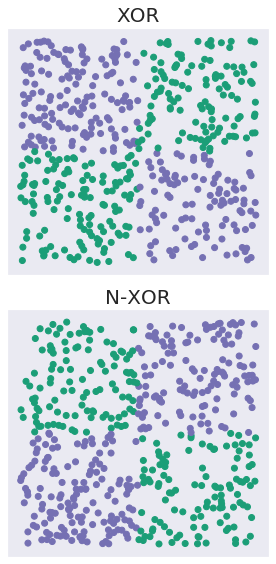

In [477]:
colors = sns.color_palette('Dark2')

np.random.seed(2)
X, labelsX = generate_parity(500, 2, angle_params=0)
temp_labelsX = []
    
# Target task
Z, labelsZ = generate_parity(500, 2, angle_params=np.pi)
# Z = Z @ generate_2d_rotation(theta=np.pi)
temp_labelsZ = []

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append(colors[2])
    else:
        temp_labelsX.append(colors[0])
       
for i in range(len(labelsZ)):
    if labelsZ[i] == 0:
        temp_labelsZ.append(colors[0])
    else:
        temp_labelsZ.append(colors[2])

sns.set()
fig0 = plt.figure(figsize=(4,8))
fig0.subplots_adjust(wspace=0.1, hspace=0.1)

ax01 = fig0.add_subplot(2, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax02 = fig0.add_subplot(2, 1, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])


ax01.scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax02.scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)

ax01.set_title('XOR', fontsize=20)
ax02.set_title('N-XOR', fontsize=20)
fig0.tight_layout()

# plt.savefig('xor_nxor_tall.png', dpi=500)

In [493]:
# This block runs parity experiments for exactly two tasks. 
# The experiments take a while, so i always run them on syntaptomes 1/2

from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

algorithms = ['Uncertainty Forest', 'Transfer Forest', 'Lifelong Forest']
algorithms = np.concatenate((algorithms, ['Uncertainty Forest', 'Transfer Forest', 'Lifelong Forest']))

n_algs = len(algorithms)
colors = sns.color_palette("Set1", n_colors = n_algs)
colors = [colors[1], colors[5], colors[0]]

In [479]:
n_mc = 100 # number of simulation repititions

n_xor = 100
n_nxor = (100*np.arange(0.5, 4.25, step=0.25)).astype(int) # number of training samples 

m = 10000 # number of test samples each monte carlo iteration

mean_error_xor_nxor = np.zeros((n_algs, len(n_nxor)))
std_error_xor_nxor = np.zeros((n_algs, len(n_nxor)))

d = 2
for j, n in enumerate(tqdm(n_nxor)):
    condensed_func = lambda x : transfer_experiment(n_xor, x, d, angle_params=np.pi, m=m)
    
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(n_mc)))
    
    mean_error_xor_nxor[:, j] = np.mean(temp_errors, axis=0)
    std_error_xor_nxor[:, j] = np.std(temp_errors, ddof=1, axis=0)











  0%|          | 0/15 [00:00<?, ?it/s]









  7%|▋         | 1/15 [00:17<03:58, 17.03s/it]









 13%|█▎        | 2/15 [00:35<03:47, 17.50s/it]









 20%|██        | 3/15 [00:56<03:41, 18.42s/it]









 27%|██▋       | 4/15 [01:17<03:32, 19.35s/it]









 33%|███▎      | 5/15 [01:40<03:24, 20.41s/it]









 40%|████      | 6/15 [02:04<03:13, 21.48s/it]









 47%|████▋     | 7/15 [02:29<03:00, 22.53s/it]









 53%|█████▎    | 8/15 [02:56<02:46, 23.79s/it]









 60%|██████    | 9/15 [03:22<02:26, 24.47s/it]









 67%|██████▋   | 10/15 [03:49<02:06, 25.28s/it]









 73%|███████▎  | 11/15 [04:18<01:45, 26.26s/it]









 80%|████████  | 12/15 [04:47<01:21, 27.33s/it]









 87%|████████▋ | 13/15 [05:17<00:56, 28.04s/it]









 93%|█████████▎| 14/15 [05:48<00:28, 28.85s/it]









100%|██████████| 15/15 [06:20<00:00, 29.90s/it]

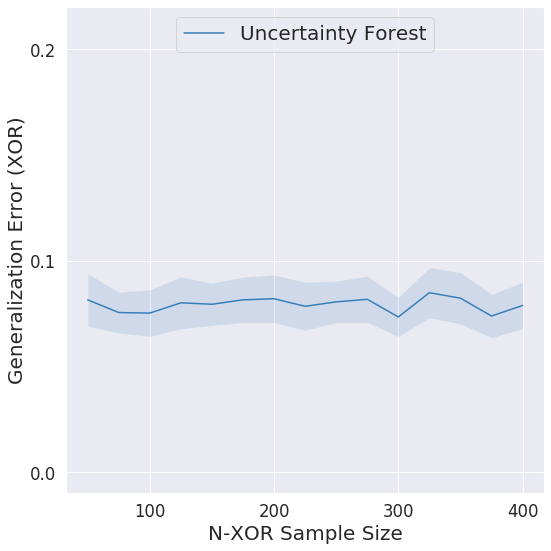

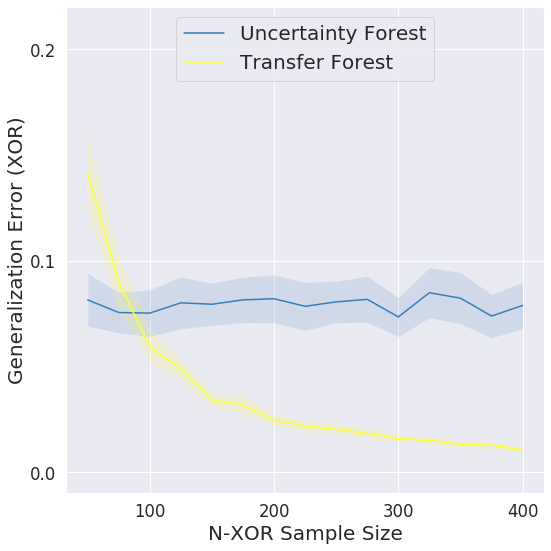

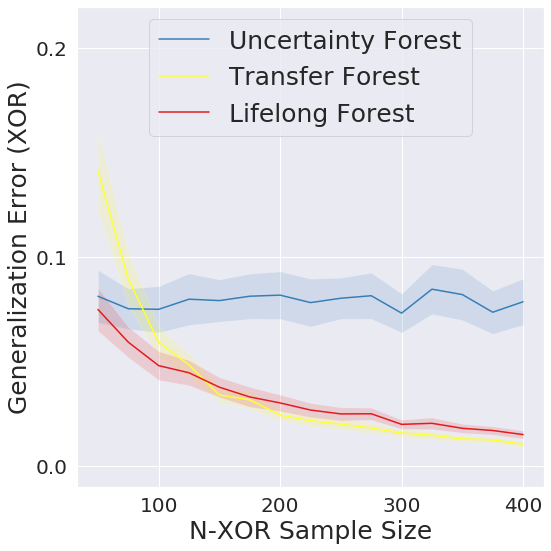

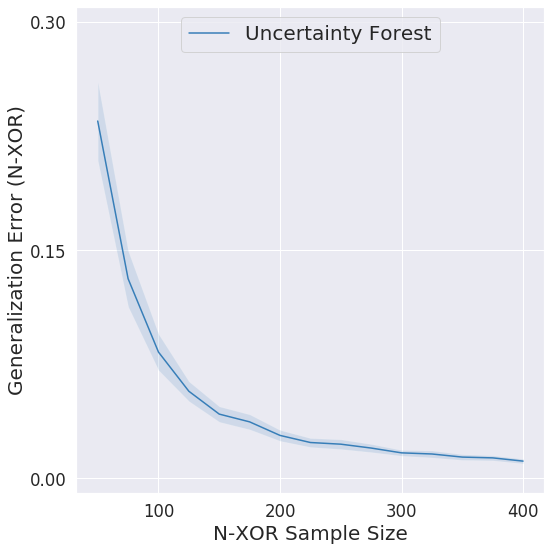

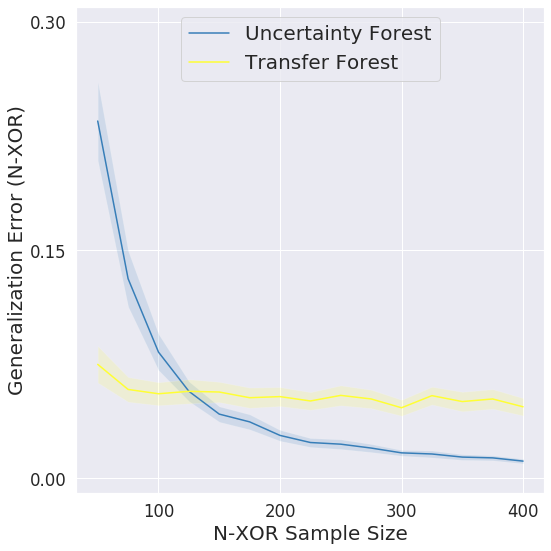

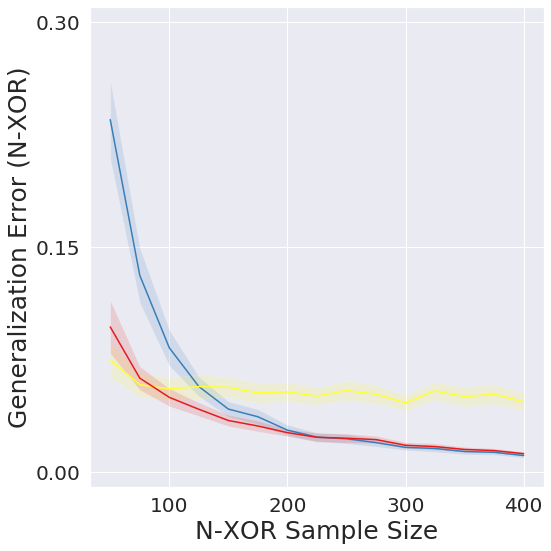

In [494]:
# plotting cell.. 
# colors = sns.color_palette("Set1", n_colors = n_algs)

algorithms = ['Uncertainty Forest', 'Transfer Forest', 'Lifelong Forest']
algorithms = np.concatenate((algorithms, ['Uncertainty Forest', 'Transfer Forest', 'Lifelong Forest']))
    
algo_offset=0
names = ['rf', 'transfer', 'lifelong']
for j, name in enumerate(names):
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[:j+1]):
        ax1.plot(n_nxor, mean_error_xor_nxor[i + algo_offset], label=algo, c=colors[i])
        ax1.fill_between(n_nxor, 
                mean_error_xor_nxor[i + algo_offset] + 1.96*std_error_xor_nxor[i + algo_offset]/np.sqrt(n_mc), 
                mean_error_xor_nxor[i + algo_offset] - 1.96*std_error_xor_nxor[i + algo_offset]/np.sqrt(n_mc), 
                where=mean_error_xor_nxor[i + algo_offset] + 1.96*std_error_xor_nxor[i + algo_offset]/np.sqrt(n_mc) >= mean_error_xor_nxor[i + algo_offset] - 1.96*std_error_xor_nxor[i + algo_offset]/np.sqrt(n_mc), 
                facecolor=colors[i], 
                alpha=0.15,
                interpolate=True)
    if name is 'lifelong':
        ax1.set_ylabel('Generalization Error (XOR)', fontsize=25)
        ax1.legend(loc='upper center', fontsize=25)
        ax1.set_ylim(-0.01, 0.22)
        ax1.set_xlabel('N-XOR Sample Size', fontsize=25)
        ax1.tick_params(labelsize=20)
        ax1.set_yticks([0, 0.1, 0.2])
        ax1.set_xticks([100, 200, 300, 400])
    else:
        ax1.set_ylabel('Generalization Error (XOR)', fontsize=20)
        ax1.legend(loc='upper center', fontsize=20)
        ax1.set_ylim(-0.01, 0.22)
        ax1.set_xlabel('N-XOR Sample Size', fontsize=20)
        ax1.set_yticks([0, 0.1, 0.2])
        ax1.set_xticks([100, 200, 300, 400])
    plt.tight_layout()
    
    plt.savefig('xor_nxor_%s.png'%(name), dpi=500)
    
algo_offset=3
for j, name in enumerate(names):
    fig2 = plt.figure(figsize=(8,8))

    ax2 = fig2.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[:j+1]):
        ax2.plot(n_nxor, mean_error_xor_nxor[i+algo_offset], label=algo, c=colors[i])
        ax2.fill_between(n_nxor, 
                mean_error_xor_nxor[i+algo_offset] + 1.96*std_error_xor_nxor[i+algo_offset]/np.sqrt(n_mc), 
                mean_error_xor_nxor[i+algo_offset] - 1.96*std_error_xor_nxor[i+algo_offset]/np.sqrt(n_mc), 
                where=mean_error_xor_nxor[i+algo_offset] + 1.96*std_error_xor_nxor[i+algo_offset]/np.sqrt(n_mc) >= mean_error_xor_nxor[i+algo_offset] - 1.96*std_error_xor_nxor[i+algo_offset]/np.sqrt(n_mc), 
                facecolor=colors[i], 
                alpha=0.15,
                interpolate=True)
        
    if name is 'lifelong':
        ax2.set_ylabel('Generalization Error (N-XOR)', fontsize=25)
#         ax2.legend(loc='upper center', fontsize=25)
        ax2.set_ylim(-0.01, 0.31)
        ax2.set_xlabel('N-XOR Sample Size', fontsize=25)
        ax2.tick_params(labelsize=20)
        ax2.set_yticks([0, 0.15, 0.3])
        ax2.set_xticks([100, 200, 300, 400])
    
    else:
        ax2.set_ylabel('Generalization Error (N-XOR)', fontsize=20)
        ax2.legend(loc='upper center', fontsize=20)
        ax2.set_ylim(-0.01, 0.31)
        ax2.set_xlabel('N-XOR Sample Size', fontsize=20)
        ax2.set_yticks([0, 0.15, 0.3])
        ax2.set_xticks([100, 200, 300, 400])
    plt.tight_layout()
    
    plt.savefig('nxor_xor_%s.png'%(name), dpi=500)

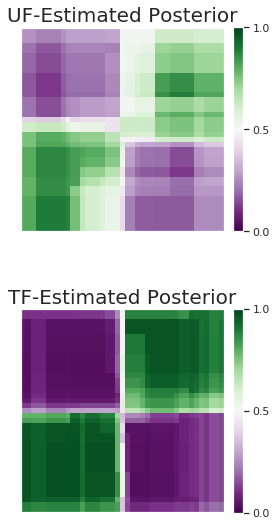

In [506]:
np.random.seed(1)

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='PRGn')

d=2
m=100
n_algs=6

sns.set()
fig3 = plt.figure(figsize=(4,8))
fig3.subplots_adjust(wspace=0.1, hspace=0.1)

ax31 = fig3.add_subplot(2, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax32 = fig3.add_subplot(2, 1, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# ax33 = fig3.add_subplot(3, 1, 3, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

posteriors = transfer_experiment(100, 300, d, m=m, return_posteriors=True)

# fig, ax = plt.subplots(1,1, figsize=(8,8))
s = int(np.sqrt(posteriors[2].shape[0]))
ax31.imshow(posteriors[0][:, 0].reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax31.set_xticks([])
ax31.set_yticks([])
ax31.set_title('UF-Estimated Posterior', fontsize=20)
fig3.colorbar(sm, ax=ax31, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
# plt.savefig('posterior_heatmap_xor_nxor_rf.png',dpi=500)

# fig, ax = plt.subplots(1,1, figsize=(8,8))
ax32.imshow(posteriors[1][:, 0].reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax32.set_xticks([])
ax32.set_yticks([])
ax32.set_title('TF-Estimated Posterior', fontsize=20)
fig3.colorbar(sm, ax=ax32, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

# ax33.imshow(((posteriors[0][:, 0] + posteriors[1][:, 0])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
# ax33.set_xticks([])
# ax33.set_yticks([])
# ax33.set_title('L2F-Estimated Posterior', fontsize=20)
# fig3.colorbar(sm, ax=ax33, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.savefig('xor_nxor_df_tf_posteriors.png', dpi=500)

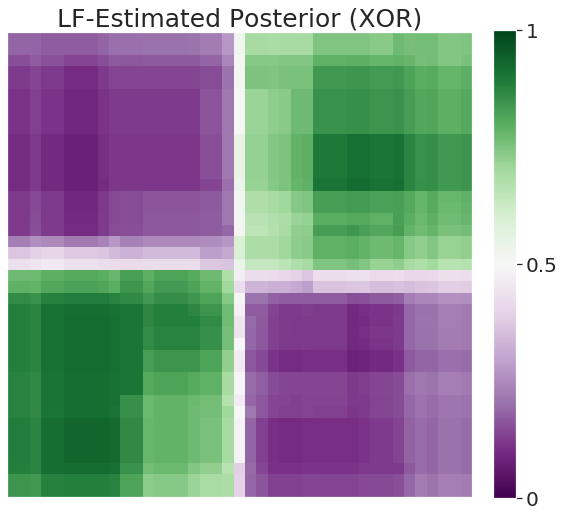

In [508]:
fig3a = plt.figure(figsize=(8,8))
ax3a = fig3a.add_subplot(1, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax3a.imshow(((posteriors[0][:, 0] + posteriors[1][:, 0])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_title('LF-Estimated Posterior (XOR)', fontsize=25)
cbar = fig3a.colorbar(sm, ax=ax3a, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels([0, 0.5, 1], fontsize=20)
# fig3a.colorbar(sm, ax=ax3a, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('xor-nxor-l2f-posterior-xor.png', dpi=500)

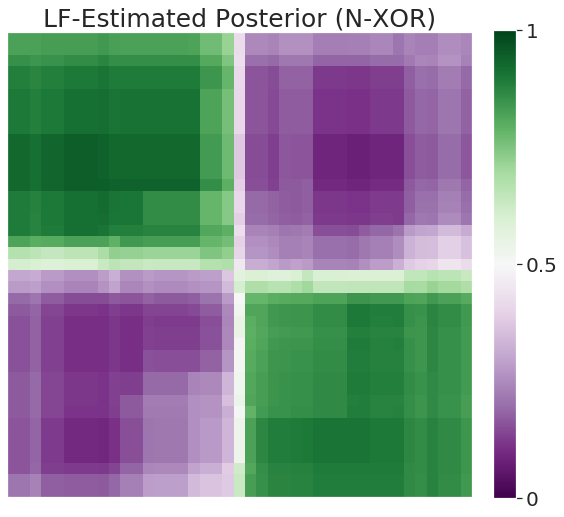

In [509]:
fig3b = plt.figure(figsize=(8,8))
ax3b = fig3b.add_subplot(1, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax3b.imshow(((posteriors[2][:, 0] + posteriors[3][:, 0])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax3b.set_xticks([])
ax3b.set_yticks([])
ax3b.set_title('LF-Estimated Posterior (N-XOR)', fontsize=25)
cbar = fig3b.colorbar(sm, ax=ax3b, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels([0, 0.5, 1], fontsize=20)

plt.tight_layout()
plt.savefig('xor-nxor-l2f-posterior-nxor.png', dpi=500)

In [ ]:
# fig 2 - R-XOR to XOR (left - XOR / RXOR, center - Error on XOR (DF/TF), right - posteriors (DF/TF))

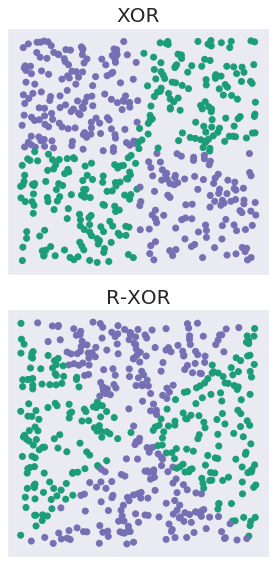

In [441]:
np.random.seed(2)
colors = sns.color_palette('Dark2')

X, labelsX = generate_parity(500, 2, angle_params=0)
temp_labelsX = []
    
Z, labelsZ = generate_parity(500, 2, angle_params=np.pi/4)
temp_labelsZ = []

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append(colors[2])
    else:
        temp_labelsX.append(colors[0])
       
for i in range(len(labelsZ)):
    if labelsZ[i] == 0:
        temp_labelsZ.append(colors[0])
    else:
        temp_labelsZ.append(colors[2])

sns.set()
fig4 = plt.figure(figsize=(4,8))
fig4.subplots_adjust(wspace=0.1, hspace=0.1)

ax41 = fig4.add_subplot(2, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax42 = fig4.add_subplot(2, 1, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])


ax41.scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax42.scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)

ax41.set_title('XOR', fontsize=20)
ax42.set_title('R-XOR', fontsize=20)
fig4.tight_layout()

plt.savefig('xor_rxor_tall.png', dpi=500)

In [482]:
# This block runs parity experiments for exactly two tasks. 
# The experiments take a while, so i always run them on syntaptomes 1/2

from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# algorithms = ['Decision Forest (DF) XOR', 'Transfer Forest (TF) XOR', 'Lifelong Forests (L2F) XOR']
# algorithms = np.concatenate((algorithms, ['Decision Forest (DF) R-XOR', 'Transfer Forest (TF) R-XOR', 'Lifelong Forests (L2F) R-XOR']))

n_algs = len(algorithms)

colors = sns.color_palette("Set1", n_colors = n_algs)
colors = [colors[1], colors[3], colors[0]]

In [483]:
n_mc = 50 # number of simulation repititions

n_xor = 100
n_rxor = (100*np.arange(0.5, 4.25, step=0.25)).astype(int) # number of training samples 

m = 10000 # number of test samples each monte carlo iteration

mean_error_xor_rxor = np.zeros((n_algs, len(n_rxor)))
std_error_xor_rxor = np.zeros((n_algs, len(n_rxor)))

d = 2
for j, n in enumerate(tqdm(n_rxor)):
    condensed_func = lambda x : transfer_experiment(n_xor, x, d, angle_params=np.pi/4, m=m)
    
    temp_errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(n_mc)))
    
    mean_error_xor_rxor[:, j] = np.mean(temp_errors, axis=0)
    std_error_xor_rxor[:, j] = np.std(temp_errors, ddof=1, axis=0)











  0%|          | 0/15 [00:00<?, ?it/s]









  7%|▋         | 1/15 [00:10<02:20, 10.06s/it]









 13%|█▎        | 2/15 [00:20<02:12, 10.20s/it]









 20%|██        | 3/15 [00:31<02:06, 10.52s/it]









 27%|██▋       | 4/15 [00:43<01:58, 10.78s/it]









 33%|███▎      | 5/15 [00:55<01:51, 11.20s/it]









 40%|████      | 6/15 [01:08<01:44, 11.64s/it]









 47%|████▋     | 7/15 [01:22<01:40, 12.56s/it]









 53%|█████▎    | 8/15 [01:36<01:31, 13.00s/it]









 60%|██████    | 9/15 [01:50<01:19, 13.33s/it]









 67%|██████▋   | 10/15 [02:05<01:08, 13.72s/it]









 73%|███████▎  | 11/15 [02:20<00:56, 14.21s/it]









 80%|████████  | 12/15 [02:37<00:44, 14.91s/it]









 87%|████████▋ | 13/15 [02:53<00:30, 15.23s/it]









 93%|█████████▎| 14/15 [03:10<00:15, 15.66s/it]









100%|██████████| 15/15 [03:27<00:00, 16.24s/it]

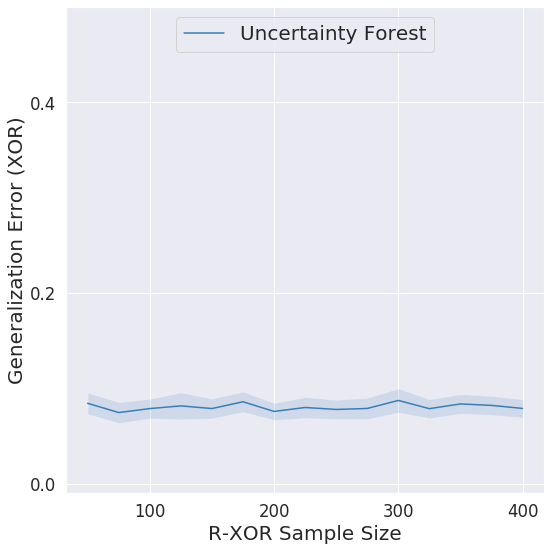

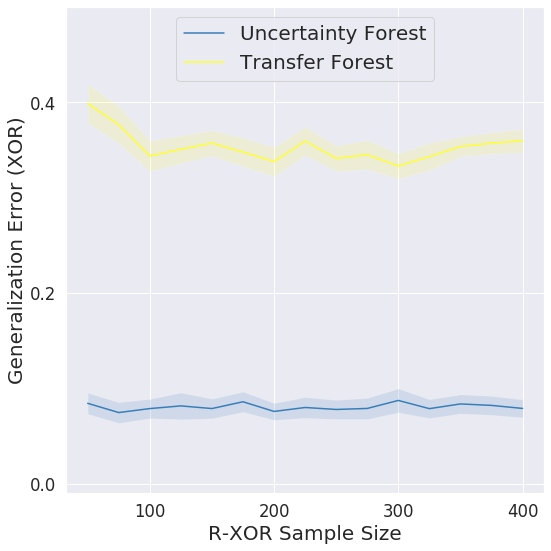

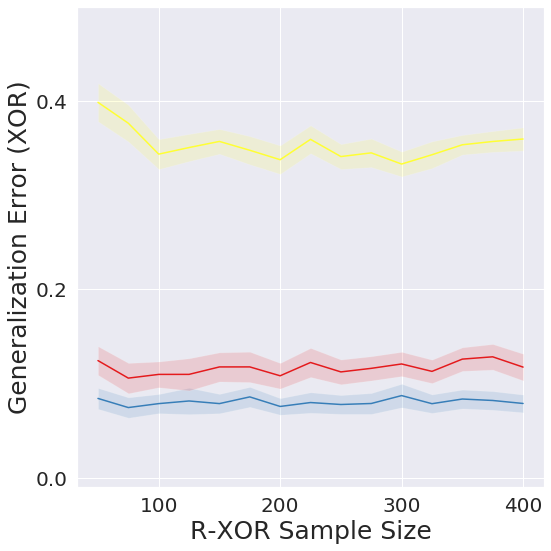

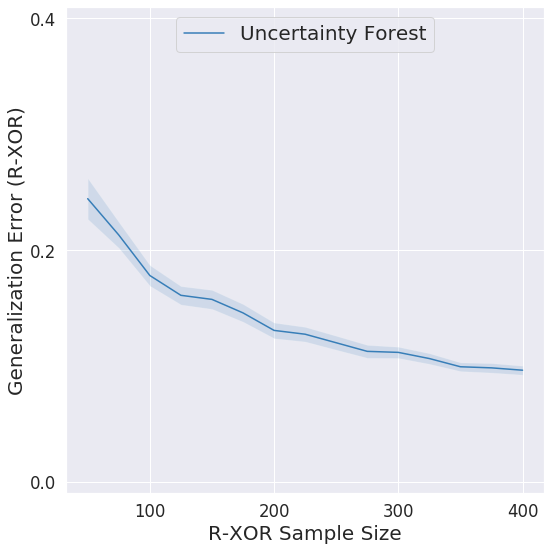

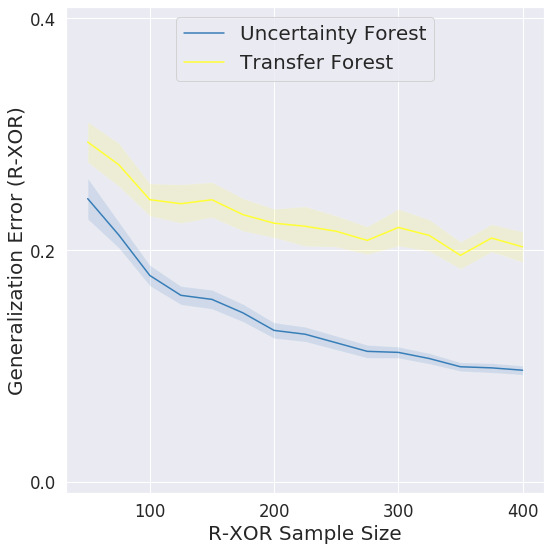

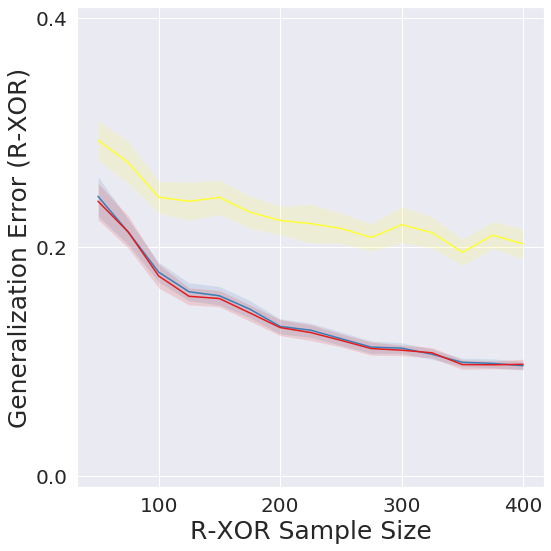

In [495]:
# plotting cell.. 
    
algo_offset=0
names = ['rf', 'transfer', 'lifelong']
for j, name in enumerate(names):
    fig5 = plt.figure(figsize=(8,8))
    ax5 = fig5.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[:j+1]):
        ax5.plot(n_rxor, mean_error_xor_rxor[i + algo_offset], label=algo, c=colors[i])
        ax5.fill_between(n_rxor, 
                mean_error_xor_rxor[i + algo_offset] + 1.96*std_error_xor_rxor[i + algo_offset]/np.sqrt(n_mc), 
                mean_error_xor_rxor[i + algo_offset] - 1.96*std_error_xor_rxor[i + algo_offset]/np.sqrt(n_mc), 
                where=mean_error_xor_rxor[i + algo_offset] + 1.96*std_error_xor_rxor[i + algo_offset]/np.sqrt(n_mc) >= mean_error_xor_rxor[i + algo_offset] - 1.96*std_error_xor_rxor[i + algo_offset]/np.sqrt(n_mc), 
                facecolor=colors[i], 
                alpha=0.15,
                interpolate=True)
        
    if name is 'lifelong':
        ax5.set_ylabel('Generalization Error (XOR)', fontsize=25)
#         ax5.legend(loc='upper center', fontsize=25)
        ax5.set_ylim(-0.01, 0.5)
        ax5.set_xlabel('R-XOR Sample Size', fontsize=25)
        ax5.set_yticks([0, 0.2, 0.4])
        ax5.set_xticks([100, 200, 300, 400])
        ax5.tick_params(labelsize=20)
    else:
        ax5.set_ylabel('Generalization Error (XOR)', fontsize=20)
        ax5.legend(loc='upper center', fontsize=20)
        ax5.set_ylim(-0.01, 0.5)
        ax5.set_xlabel('R-XOR Sample Size', fontsize=20)
        ax5.set_yticks([0, 0.2, 0.4])
        ax5.set_xticks([100, 200, 300, 400])

    plt.tight_layout()
    plt.savefig('xor_rxor_%s.png'%(name), dpi=500)
    
algo_offset=3
for j, name in enumerate(names):
    fig6 = plt.figure(figsize=(8,8))

    ax6 = fig6.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[:j+1]):
        ax6.plot(n_rxor, mean_error_xor_rxor[i+algo_offset], label=algo, c=colors[i])
        ax6.fill_between(n_rxor, 
                mean_error_xor_rxor[i+algo_offset] + 1.96*std_error_xor_rxor[i+algo_offset]/np.sqrt(n_mc), 
                mean_error_xor_rxor[i+algo_offset] - 1.96*std_error_xor_rxor[i+algo_offset]/np.sqrt(n_mc), 
                where=mean_error_xor_rxor[i+algo_offset] + 1.96*std_error_xor_rxor[i+algo_offset]/np.sqrt(n_mc) >= mean_error_xor_rxor[i+algo_offset] - 1.96*std_error_xor_rxor[i+algo_offset]/np.sqrt(n_mc), 
                facecolor=colors[i], 
                alpha=0.15,
                interpolate=True)
    if name is 'lifelong':
        ax6.set_ylabel('Generalization Error (R-XOR)', fontsize=25)
#         ax6.legend(loc='upper center', fontsize=25)
        ax6.set_ylim(-0.01, 0.41)
        ax6.set_xlabel('R-XOR Sample Size', fontsize=25)
        ax6.set_yticks([0, 0.2, 0.4])
        ax6.set_xticks([100, 200, 300, 400])
        ax6.tick_params(labelsize=20)
    else:
        ax6.set_ylabel('Generalization Error (R-XOR)', fontsize=20)
        ax6.legend(loc='upper center', fontsize=20)
        ax6.set_ylim(-0.01, 0.41)
        ax6.set_xlabel('R-XOR Sample Size', fontsize=20)
        ax6.set_yticks([0, 0.2, 0.4])
        ax6.set_xticks([100, 200, 300, 400])
    plt.tight_layout()
    plt.savefig('rxor_xor_%s.png'%(name), dpi=500)

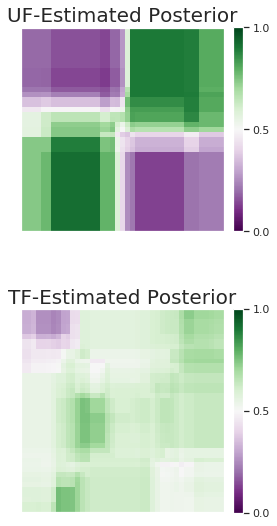

In [501]:
np.random.seed(1)

from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='PRGn')

d=2
m=100
n_algs=6

posteriors = transfer_experiment(100, 300, d, m=m, angle_params=np.pi/4,return_posteriors=True)
s = int(np.sqrt(posteriors[0].shape[0]))

sns.set()
fig7 = plt.figure(figsize=(4,8))
fig7.subplots_adjust(wspace=0.1, hspace=0.1)

ax71 = fig7.add_subplot(2, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax72 = fig7.add_subplot(2, 1, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# ax71 = fig7.add_subplot(3, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# ax72 = fig7.add_subplot(3, 1, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# ax73 = fig7.add_subplot(3, 1, 3, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# ax73.imshow(((posteriors[0][:, 0] + posteriors[1][:, 0])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
# ax73.set_xticks([])
# ax73.set_yticks([])
# ax73.set_title('L2F-Estimated Posterior', fontsize=20)
# fig7.colorbar(sm, ax=ax73, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)



# fig, ax = plt.subplots(1,1, figsize=(8,8))
s = int(np.sqrt(posteriors[2].shape[0]))
ax71.imshow(posteriors[0][:, 0].reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax71.set_xticks([])
ax71.set_yticks([])
ax71.set_title('UF-Estimated Posterior', fontsize=20)
fig7.colorbar(sm, ax=ax71, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
# plt.savefig('posterior_heatmap_xor_nxor_rf.png',dpi=500)

# fig, ax = plt.subplots(1,1, figsize=(8,8))
ax72.imshow(posteriors[1][:, 0].reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax72.set_xticks([])
ax72.set_yticks([])
ax72.set_title('TF-Estimated Posterior', fontsize=20)
fig7.colorbar(sm, ax=ax72, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.savefig('xor_rxor_df_tf_posteriors.png', dpi=500)

In [ ]:
# fig 3 - N-XOR and XOR (left - XOR L2F posterior, left center - Error on XOR (DF/TF/L2F),
#                        right center - Error on N-XOR (DF/TF/L2F), right - N-XOR L2F posterior)

In [ ]:
# fig 4 - R-XOR and XOR (left - XOR L2F posterior, left center - Error on XOR (DF/TF/L2F),
#                        right center - Error on R-XOR (DF/TF/L2F), right - R-XOR L2F posterior)

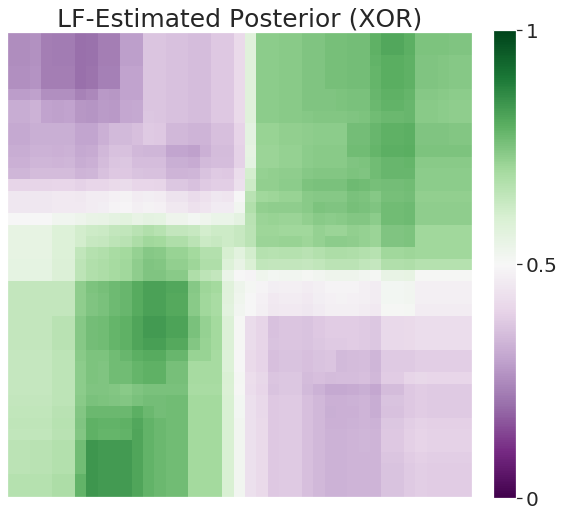

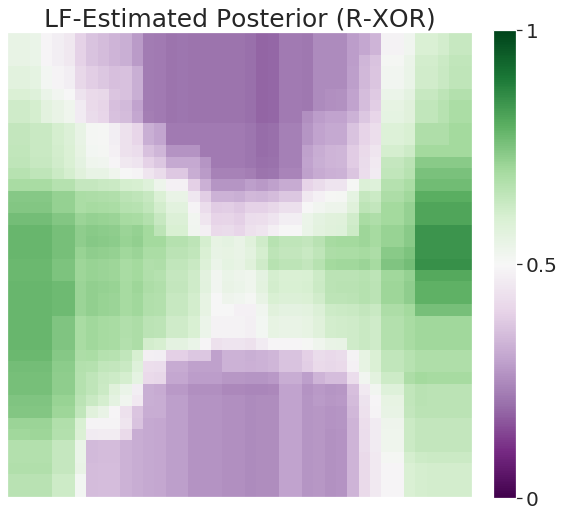

In [505]:
fig7a = plt.figure(figsize=(8,8))
ax7a = fig7a.add_subplot(1, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax7a.imshow(((posteriors[0][:, 0] + posteriors[1][:, 0])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax7a.set_xticks([])
ax7a.set_yticks([])
ax7a.set_title('LF-Estimated Posterior (XOR)', fontsize=25)
cbar = fig7a.colorbar(sm, ax=ax7a, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels([0, 0.5, 1], fontsize=20)

plt.tight_layout()
plt.savefig('xor-rxor-l2f-posterior-xor.png', dpi=500)

fig7b = plt.figure(figsize=(8,8))
ax7b = fig7b.add_subplot(1, 1, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax7b.imshow(((posteriors[2][:, 1] + posteriors[3][:, 1])/2).reshape((s,s)), vmin=0, vmax=1, cmap='PRGn')
ax7b.set_xticks([])
ax7b.set_yticks([])
ax7b.set_title('LF-Estimated Posterior (R-XOR)', fontsize=25)

cbar = fig7b.colorbar(sm, ax=ax7b, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels([0, 0.5, 1], fontsize=20)

plt.tight_layout()
plt.savefig('xor-rxor-l2f-posterior-rxor.png', dpi=500)

In [ ]:
# fig 5 - 10 R-XORs (task 1 = XOR, task 10 = pi/4 R-XOR)

In [366]:
# Stuff in action
from tqdm import tqdm

np.random.seed(2)

n_mc=10 # n monte carlo iterations
n_training_sets=30
# ns=[75, 100, 125, 150, 200] # amount of data from each task 
m=300 # amount of data from each task to estimate the risk
# d=2 # dimension of parity problem

# h= 1 / 64
# fracs = np.random.uniform(0, pi, size=10)
# fracs = np.pi*np.random.uniform(0, 0.125, size=9)
# fracs = np.pi*np.arange(h, 0.125 + h, step=h)
# fracs = np.concatenate(([0], fracs, [np.pi/4]))
fracs = np.pi/4*np.ones(9)
fracs = np.concatenate(([0], fracs))

n_tasks = len(fracs)
ns = n_tasks * [75]

# optimal_ratios = np.zeros((n_mc, n_tasks))
fracs

array([0.        , 0.78539816, 0.78539816, 0.78539816, 0.78539816,
       0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816])

In [367]:
errors = [np.zeros((n_tasks-i, n_mc)) for i in range(n_tasks)]
STL_errors = np.zeros((n_tasks, n_mc))

ratios = [np.zeros((n_tasks-i, n_mc)) for i in range(n_tasks)]

d=2
for _ in tqdm(range(n_mc)):
    for i in range(n_tasks):
        risks = np.zeros((i+1,n_training_sets)) 
        STL_risks = np.zeros(n_training_sets) 
        for s in range(n_training_sets):
            L2F = LifelongForest()
            for j, f in enumerate(fracs[:i+1]):
                temp_X, temp_y = generate_parity(ns[j], d, angle_params=f)
                L2F.new_forest(temp_X, temp_y, n_estimators=int(np.sqrt(ns[j])))
                
            for j, f in enumerate(fracs[:i+1]):
                test_X, test_y = generate_parity(m, d, angle_params=f)

                risks[j,s] = 1 - np.sum(L2F.predict(test_X, representation='all', decider=j) == test_y)/m
            STL_risks[s] = 1 - np.sum(L2F.predict(test_X, representation=i, decider=i) == test_y)/m
                
        STL_errors[i, _] = np.mean(STL_risks)
        
        average_risks = np.mean(risks, axis=1)
        for j in range(i+1):
            errors[j][i-j, _] = average_risks[j]
            
    for i in range(n_tasks):
        ratios[i][:, _] = STL_errors[i, _] / errors[i][:, _]
    
            
        
        
#         ratios[_] = STL_errors[_] / errors[_] 
#         print(ratios[_])
    #         L2F_optimal = LifelongForest()
    #         temp_X, temp_y = generate_parity(np.sum(ns), d, angle_params=th, acorn=_*i)
    #         L2F_optimal.new_forest(temp_X, temp_y, n_estimators=int(np.sqrt(np.sum(ns))))

#         errors[_] = np.mean(risks, axis=1)
    #             if j == i:
    #                 optimal_accuracies[_][i] = np.sum(L2F_optimal.predict(test_X, representation=0, decider=0) == test_y)/m

#                 ratios[j][_, i-j] = (STL_accuracies[j][_, i-j]) / (accuracies[j][_, i-j])
#         optimal_ratios[_][i] = (optimal_accuracies[_][i]) / (STL_accuracies[j][_, i-j])











  0%|          | 0/10 [00:00<?, ?it/s]









 10%|█         | 1/10 [09:24<1:24:40, 564.55s/it]









 20%|██        | 2/10 [18:47<1:15:12, 564.02s/it]









 30%|███       | 3/10 [28:14<1:05:55, 565.02s/it]









 40%|████      | 4/10 [37:43<56:36, 566.12s/it]  









 50%|█████     | 5/10 [47:04<47:03, 564.69s/it]









 60%|██████    | 6/10 [56:16<37:23, 560.96s/it]









 70%|███████   | 7/10 [1:05:26<27:52, 557.57s/it]









 80%|████████  | 8/10 [1:14:40<18:32, 556.41s/it]









 90%|█████████ | 9/10 [1:23:55<09:16, 556.16s/it]









100%|██████████| 10/10 [1:33:11<00:00, 555.90s/it]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


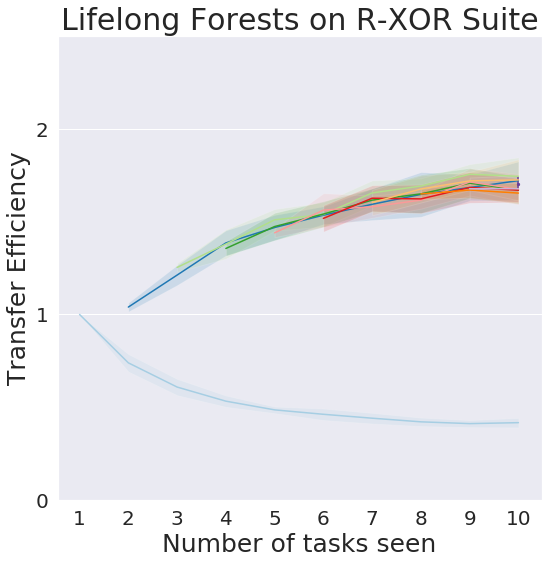

In [370]:
import seaborn as sns
sns.set()

# mean_accuracies = [np.mean(accuracies[i],axis=0) for i in range(n_tasks)]
# std_accuracies = [np.std(accuracies[i],ddof=1,axis=0) for i in range(n_tasks)]

# STL_mean_accuracies = [np.mean(STL_accuracies[i],axis=0) for i in range(n_tasks)]
# STL_std_accuracies = [np.std(STL_accuracies[i],ddof=1,axis=0) for i in range(n_tasks)]

mean_ratios = [np.mean(ratios[i],axis=1) for i in range(n_tasks)]
std_ratios = [np.std(ratios[i],ddof=1,axis=1) for i in range(n_tasks)]

# mean_opt_ratios = [np.mean(optimal_ratios[i],axis=0) for i in range(n_tasks)]

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('Paired', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
    ax.plot(ns,np.array(mean_ratios[i]), label = 'task %i'%(i+1), c=c[i])
#     ax.plot(ns, mean_ratios[i])
    
    ax.fill_between(np.arange(i+1, n_tasks+1), 
        mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(n_mc), 
        mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(n_mc), 
        where=mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(n_mc) >= mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(n_mc), 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)
    
    
ax.scatter(n_tasks, mean_ratios[-1], c = c[9], label='task %i'%(n_tasks), s = 5)
ax.errorbar(10, mean_ratios[-1], yerr=1.96*std_ratios[-1]/np.sqrt(n_mc), c=c[9])


# for i in range(n_tasks - 1):
#     ns = np.arange(i + 1, n_tasks + 1)
#     ax.plot(ns,(np.array(mean_acc[i])), ls='.', c=c[i])
#     ax.plot(ns, mean_opt_ratios[i])
    
#     ax.fill_between(np.arange(i+1, n_tasks+1), 
#         mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(nmc), 
#         mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(nmc), 
#         where=mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(nmc) >= mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(nmc), 
#         facecolor=c[i], 
#         alpha=0.15,
#         interpolate=True)
    
    
# ax.scatter(n_tasks, mean_opt_ratios[-1], 
#            c = c[9], 
#            label='th=%1.2fpi'%(fracs[-1]), 
#            s = 5)


    
ax.set_title('Lifelong Forests on R-XOR Suite', fontsize=30)
ax.set_xlabel('Number of tasks seen', fontsize=25)
ax.set_ylabel('Transfer Efficiency', fontsize=25)
# ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_yticks([1, 0.95, 0.90, 0.85, 0.80])
ax.set_ylim(0, 2.5)
ax.set_xticks(np.arange(1,n_tasks+1))
ax.set_yticks([0, 1, 2])
ax.tick_params(labelsize=20)
ax.grid(axis='x')
plt.tight_layout()
# plt.savefig('rxors_suite_1xor_9pi4_equaln75_nts30_bigfonts.png', dpi=500)

In [ ]:
sns.set()
xs = np.arange(-1, 1.01, step=0.01)
c = sns.color_palette('Paired', n_colors=10)
fracs = np.pi/4*np.ones(9)
# fracs = np.pi*np.random.uniform(0, 0.125, size=9)
fracs = np.concatenate(([0], fracs))

fig, ax = plt.subplots(1,1, figsize=(8,8))


ax.set_ylim(-0.01, 1)
ax.set_xlim(0,1)
ax.set_xticks([1])
ax.set_yticks([0, 1])
ax.tick_params(labelsize=20)

ax.axhline(0, c = c[0], linewidth=3,label='task 1')
for i, f in enumerate(fracs[1:]):
#     ax.axhline(0 + 0.01 - (i / 500), c=c[i], label='task %i'%(i+1))
    ax.plot(xs, xs*np.tan(f) + 0.01 - (i / 500), linewidth=3, c=c[i+1], label='task %i'%(i+2))
#     ax.plot(-xs, xs*np.tan(f) + 0.01 - (i / 500), c=c[i+1]) # label='task %i'%(i+2))
# ax.legend(loc='upper left', fontsize=20)
ax.set_title('Rotation angle by task', fontsize=30)
plt.tight_layout()
plt.savefig('rxors_lifelong_adversaries.png', dpi=1000)

In [372]:
import pickle
# pickle.dump(mean_ratios, open('mean_ratios_adversaries.pkl', 'wb'))

In [1]:
# fig 6 - CIFAR (left - accuracy, right - TLE)

In [ ]:
# reproduce cifar results..